<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Personal%20Projects/Detection_of_Fraudulent_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Credit Cards Dataset**</font>

We will use a real dataset of anonymous credit card transactions made by European cardholders as of September 2013. These transactions are labeled as fraudulent or genuine, and the goal is to create a fraud detection solution using machine learning to predict the correct labels for new instances.
This data set is very unbalanced. Of the 284,807 transactions, only 492 are fraudulent (0.172%). This low fraud rate is quite typical of credit card transactions. There are 28 variables, all of them numeric, and there are no categorical variables. These variables are not the original characteristics, but the result of a principal component analysis.

To deal with unbalanced datasets it is recommended to use the imblearn library. In it there are several methods to balance the data. There is a subsampling method and an oversampling method (SMOTE).

## 1.- Importing Data

In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import imblearn


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importing Dataset
df_CC = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/credit_card.txt')

We do a brief exploration of the data mainly to understand what is in the data set and to validate that there is no null data.

In [5]:
df_CC.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [6]:
df_CC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

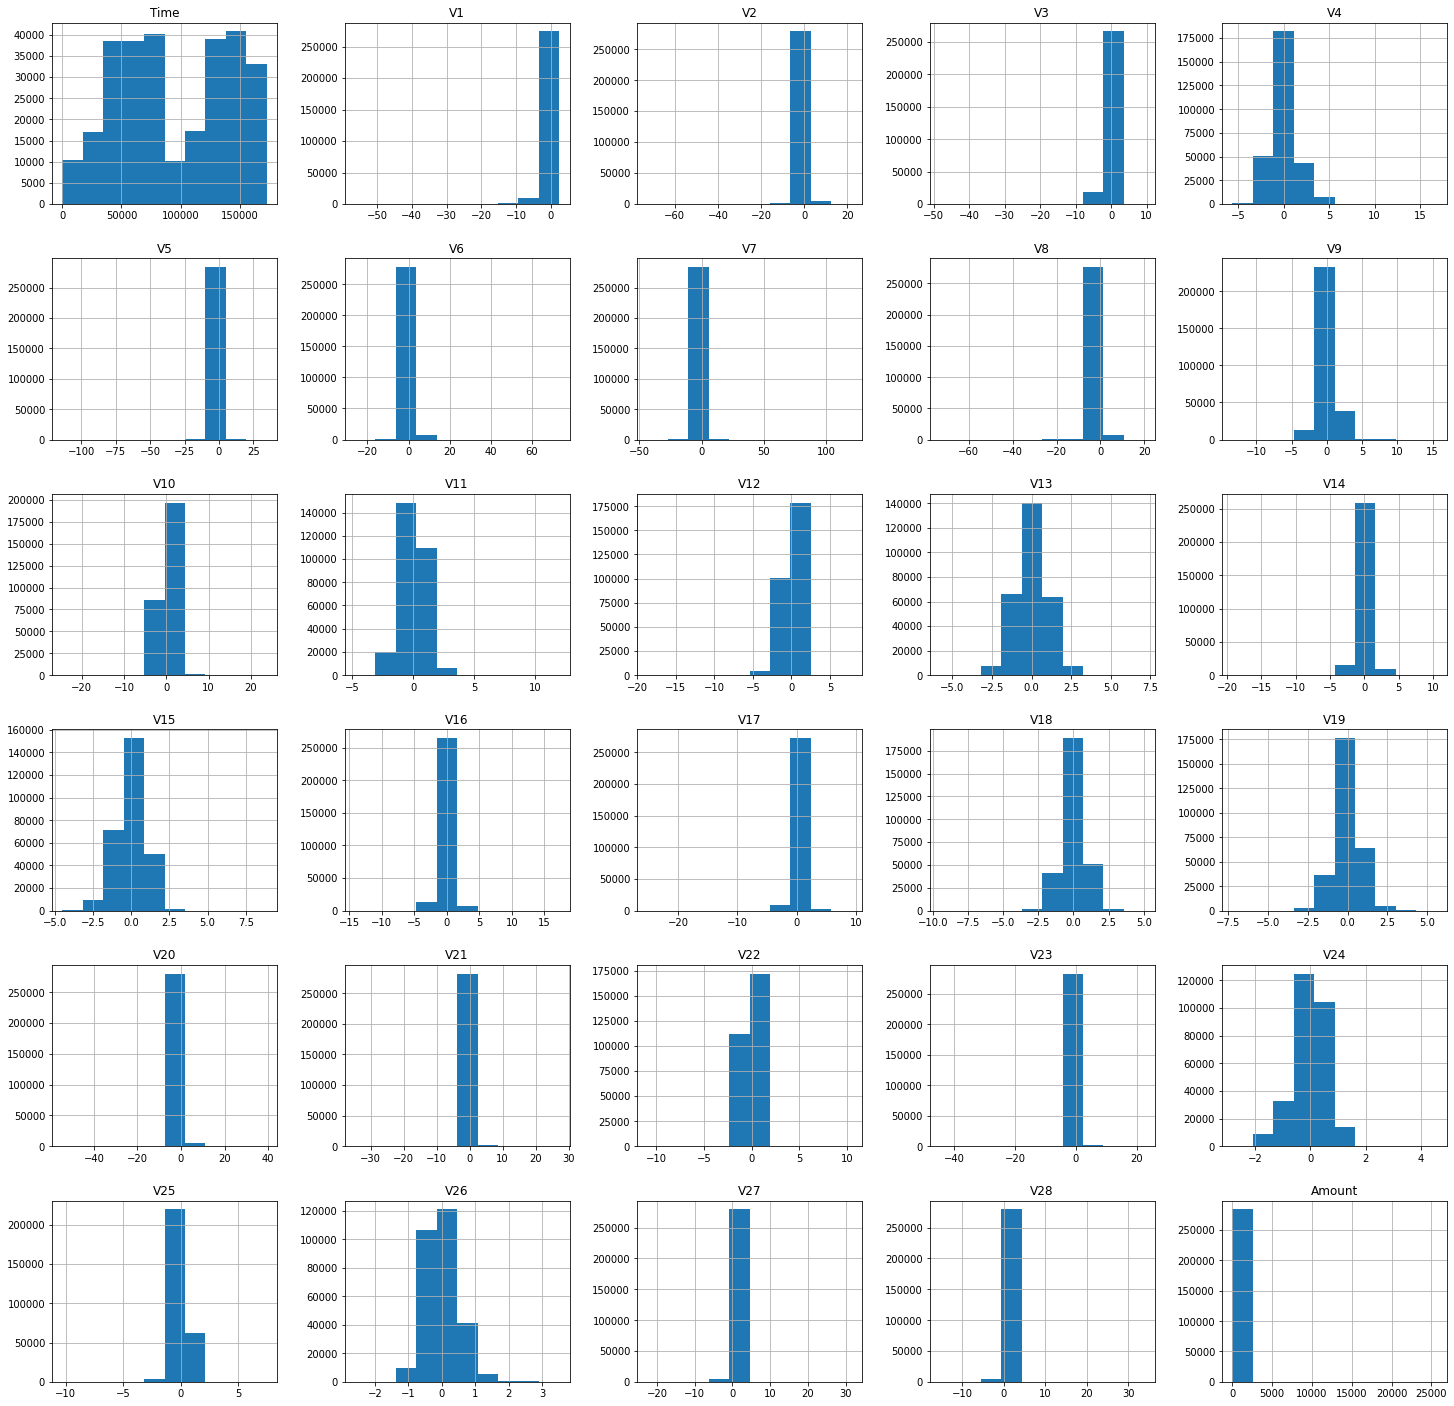

In [69]:
#Let's see how the data distributes:
df_CC.drop('Class', axis = 1).hist(figsize = (25,25))
plt.show()

As can be seen, each variable distribute in very different value ranges, especially the Amount and Time variables, which is why it will be necessary to scale the data to prevent these variables from biasing the classification model.

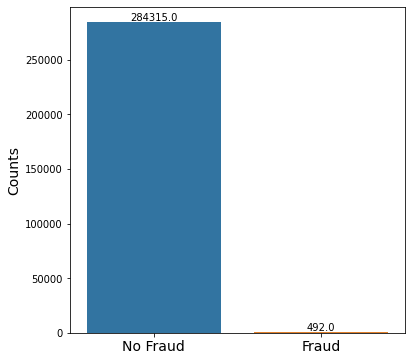

In [25]:
fig, ax = plt.subplots(1,1,figsize = (6,6));
sns.countplot(data = df_CC, x = 'Class', ax = ax);

for p in ax.patches:
    ax.annotate('{0:}'.format(p.get_height()),
                xy = (p.get_x() + 0.4, p.get_height()),
                ha='center', va = 'bottom')
plt.xticks(np.arange(2), ['No Fraud', 'Fraud'], fontsize = 14)
plt.xlabel('')
plt.ylabel('Counts', fontsize = 14);
plt.show()

The graph shows the clear imbalance between the categories "no fraud" (0)  and "fraud" (1).

## 2.- Scaling and Data Over/Under Sampling

In [26]:
#Divide the Dataframe:
y = df_CC['Class']
x = df_CC.drop('Class', axis = 1)

In [27]:
#We standardize our data frame containing information to predict whether a transaction is fraud

from sklearn.preprocessing import MinMaxScaler

MinMax = MinMaxScaler() # object of the class StandardScaler ()
x_scaled = MinMax.fit_transform(x.values)

In [28]:
# Divide train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.30, random_state = 42)

In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [30]:
# define the pipeline to perform over and under sampling at the same time
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [31]:
# we transform the data set only for the training set
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

In [33]:
from collections import Counter
# summarize the new class distribution
counter_train = Counter(y_train)
counter_train_res = Counter(y_train_res)

print(f'Counts with the original set: {counter_train}')
print(f'Counts after resampling: {counter_train_res}')


Counts with the original set: Counter({0: 199008, 1: 356})
Counts after resampling: Counter({0: 39800, 1: 19900})


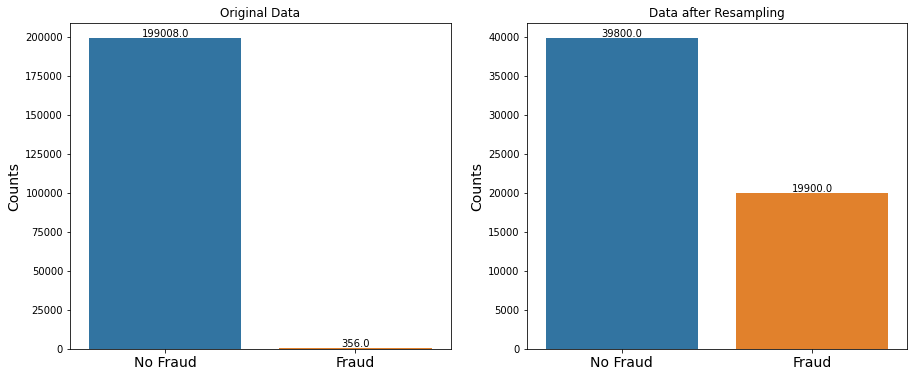

In [37]:
fig, ax = plt.subplots(1,2,figsize = (15,6));

sns.countplot(data = pd.DataFrame(y_train, columns = ['Class']), x = 'Class', ax = ax[0])
for p in ax[0].patches:
    ax[0].annotate('{0:}'.format(p.get_height()),
                xy = (p.get_x() + 0.4 , p.get_height()),
                ha='center', va = 'bottom')
ax[0].set_title('Original Data');
ax[0].set_xticks(np.arange(2), ['No Fraud', 'Fraud'], fontsize = 14)
ax[0].set_xlabel('')
ax[0].set_ylabel('Counts', fontsize = 14);

sns.countplot(data = pd.DataFrame(y_train_res, columns = ['Class']), x = 'Class', ax = ax[1])
for p in ax[1].patches:
    ax[1].annotate('{0:}'.format(p.get_height()),
                xy = (p.get_x() + 0.4 , p.get_height()),
                ha='center', va = 'bottom')
ax[1].set_title('Data after Resampling');
ax[1].set_xticks(np.arange(2), ['No Fraud', 'Fraud'], fontsize = 14)
ax[1].set_xlabel('')
ax[1].set_ylabel('Counts', fontsize = 14);

plt.show()

## 3.- Classification Models


In [52]:
def modelPerf(y_pred, y_test):
  print('Accuracy :{0:0.5f}'.format(accuracy_score(y_pred, y_test))) 
  print('AUC : {0:0.5f}'.format(roc_auc_score(y_test , y_pred)))
  print('Precision : {0:0.5f}'.format(precision_score(y_test , y_pred)))
  print('Recall : {0:0.5f}'.format(recall_score(y_test , y_pred)))
  print('F1 : {0:0.5f}\n'.format(f1_score(y_test , y_pred)))


  #Confusion Matrix:
  fig, ax = plt.subplots(1,1, figsize = (6,6))
  cmt = confusion_matrix(y_test, y_pred)
  sns.heatmap(cmt.T, square=True, annot=True, fmt='d', cbar=False, ax = ax)

  ax.set_xlabel('True label')
  ax.set_ylabel('Predicted label');
  ax.set_title('Performance of the Model');
  plt.show();

### 3.1.- Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression 

Accuracy :0.99924
AUC : 0.90418
Precision : 0.73826
Recall : 0.80882
F1 : 0.77193



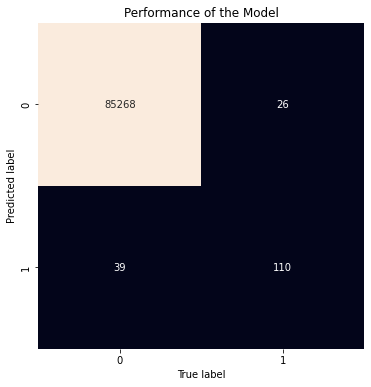

In [53]:
lr = LogisticRegression(C=1e+3, solver='liblinear', max_iter=2);
lr.fit(X_train_res, y_train_res); 

# Prediction:
y_pred = lr.predict(X_test)

modelPerf(y_pred, y_test)

### 3.2.- Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier

Accuracy :0.99116
AUC : 0.91115
Precision : 0.13373
Recall : 0.83088
F1 : 0.23038



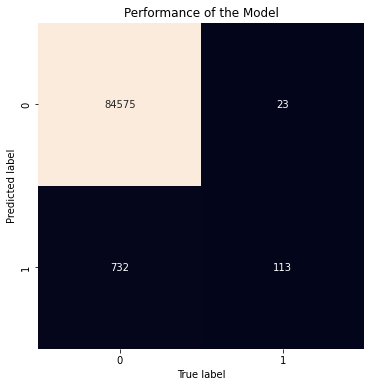

In [55]:
tree = DecisionTreeClassifier().fit(X_train_res, y_train_res) 
# Prediction:
y_pred = tree.predict(X_test)

modelPerf(y_pred, y_test)

### 3.3.- Knearest Neighbor

In [56]:
from sklearn.neighbors import KNeighborsClassifier

Accuracy :0.99480
AUC : 0.94234
Precision : 0.22000
Recall : 0.88971
F1 : 0.35277



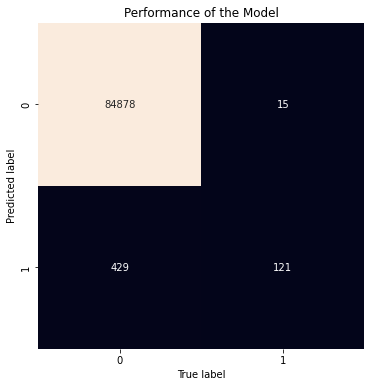

In [57]:
n_neighbors = 4

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_res, y_train_res) 

# Prediction:
y_pred = knn.predict(X_test)

modelPerf(y_pred, y_test)

## 3.- Precision - Recall Curve

In [58]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
from scikitplot.metrics import plot_precision_recall

### 3.1.- Logistic Regression

In [60]:
y_proba_lr = lr.predict_proba(X_test)

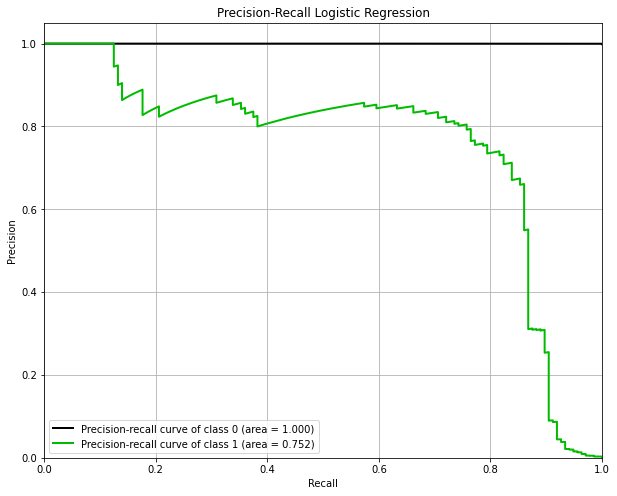

In [63]:
plot_precision_recall(y_test, y_proba_lr, title = 'Precision-Recall Logistic Regression'
, plot_micro = False, classes_to_plot = [0,1], figsize = (10,8))
plt.grid();
plt.show()

### 3.2.- Decision Tree

In [64]:
y_proba_tree = tree.predict_proba(X_test)

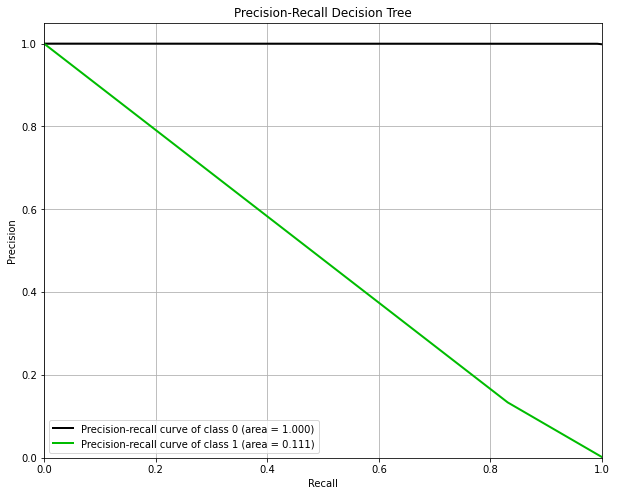

In [65]:
plot_precision_recall(y_test, y_proba_tree, title = 'Precision-Recall Decision Tree'
, plot_micro = False, classes_to_plot = [0,1], figsize = (10,8));
plt.grid();
plt.show()

### 3.3.- Knearest Neighbor

In [66]:
y_proba_knn = knn.predict_proba(X_test)

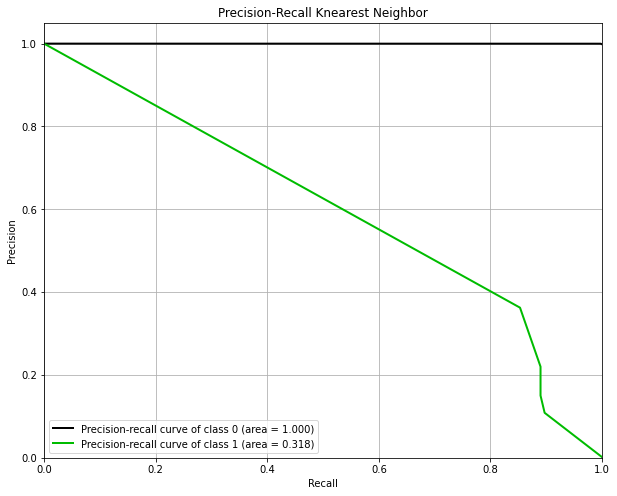

In [67]:
plot_precision_recall(y_test, y_proba_knn, title = 'Precision-Recall Knearest Neighbor'
, plot_micro = False, classes_to_plot = [0,1], figsize = (10,8))
plt.grid();
plt.show()

In general, both from the metrics perspective and from what was observed in the precision-recall curves, the model with the best performance was Logistic Regression, regardless of the data imbalance.